In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from helpers import replace_ingredient_type, replace_ingredient_type_by_name, replace_measure, split_ingredients

plt.style.use("ggplot")
solvro_colors = ["#D9E8FF", "#80B3FF", "#6583C8", "#274276", "#203560"]
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=reversed(solvro_colors))

In [2]:
df = pd.read_json("../data/cocktail_dataset.json")

In [3]:
df.columns

Index(['id', 'name', 'category', 'glass', 'tags', 'instructions', 'imageUrl',
       'alcoholic', 'createdAt', 'updatedAt', 'ingredients'],
      dtype='object')

In [4]:
df[0:5]

,id,name,category,glass,tags,instructions,imageUrl,alcoholic,createdAt,updatedAt,ingredients
0,11000,Mojito,Cocktail,Highball glass,"[IBA, ContemporaryClassic, Alcoholic, USA, Asi...",Muddle mint leaves with sugar and lime juice. ...,https://cocktails.solvro.pl/images/ingredients...,1,2024-08-18T19:01:17.000+00:00,2024-08-18T19:06:16.000+00:00,"[{'id': 170, 'name': 'Soda water', 'descriptio..."
1,11001,Old Fashioned,Cocktail,Old-fashioned glass,"[IBA, Classic, Alcoholic, Expensive, Savory]",Place sugar cube in old fashioned glass and sa...,https://cocktails.solvro.pl/images/ingredients...,1,2024-08-18T19:01:58.000+00:00,2024-08-18T19:06:17.000+00:00,"[{'id': 513, 'name': 'Water', 'description': '..."
2,11002,Long Island Tea,Ordinary Drink,Highball glass,"[Strong, Asia, StrongFlavor, Brunch, Vegetaria...",Combine all ingredients (except cola) and pour...,https://cocktails.solvro.pl/images/ingredients...,1,2024-08-18T19:01:58.000+00:00,2024-08-18T19:06:17.000+00:00,"[{'id': 305, 'name': 'Light Rum', 'description..."
3,11003,Negroni,Ordinary Drink,Old-fashioned glass,"[IBA, Classic]","Stir into glass over ice, garnish and serve.",https://cocktails.solvro.pl/images/ingredients...,1,2024-08-18T19:01:58.000+00:00,2024-08-18T19:06:17.000+00:00,"[{'id': 482, 'name': 'Sweet Vermouth', 'descri..."
4,11004,Whiskey Sour,Ordinary Drink,Old-fashioned glass,"[IBA, Classic, Alcoholic, ContemporaryClassic]","Shake with ice. Strain into chilled glass, gar...",https://cocktails.solvro.pl/images/ingredients...,1,2024-08-18T19:01:59.000+00:00,2024-08-18T19:06:18.000+00:00,"[{'id': 409, 'name': 'Powdered Sugar', 'descri..."


In [5]:
print(len(df["id"].unique()))
print(len(df["id"]))
# Sprawdzenie czy wszystkie id są unikalne ujawnia, że są.

134
134


In [6]:
print(len(df["name"].unique()))
print(len(df["name"]))
# Sprawdzenie czy wszystkie nazwy są unikalne ujawnia, że są.

134
134


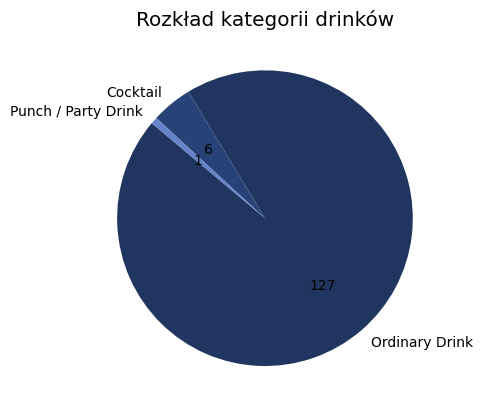

In [7]:
values = df["category"].value_counts()
plt.pie(
    values,
    labels=values.index,
    autopct=lambda x: round(values.sum() * x / 100),
    startangle=140,
)
plt.title("Rozkład kategorii drinków")
plt.show()

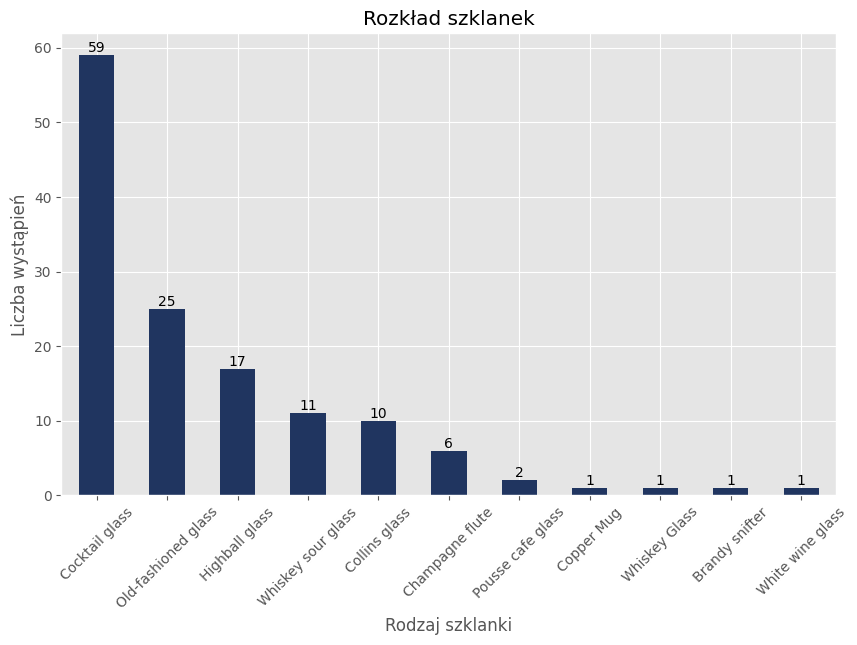

In [8]:
category_counts = df["glass"].value_counts()
plt.figure(figsize=(10, 6))
category_counts.plot(kind="bar")
plt.xlabel("Rodzaj szklanki")
plt.ylabel("Liczba wystąpień")
plt.title("Rozkład szklanek")
plt.xticks(rotation=45)
plt.bar_label(plt.gca().containers[0])
plt.show()

In [9]:
# postarałem się zdobyć wiedzę dziedzinową i po googlowaniu dowiedziałem się,
# że w tych danych nie ma szklanek, które nie istnieją, albo dwóch różnych nazw dla jednej szklanki

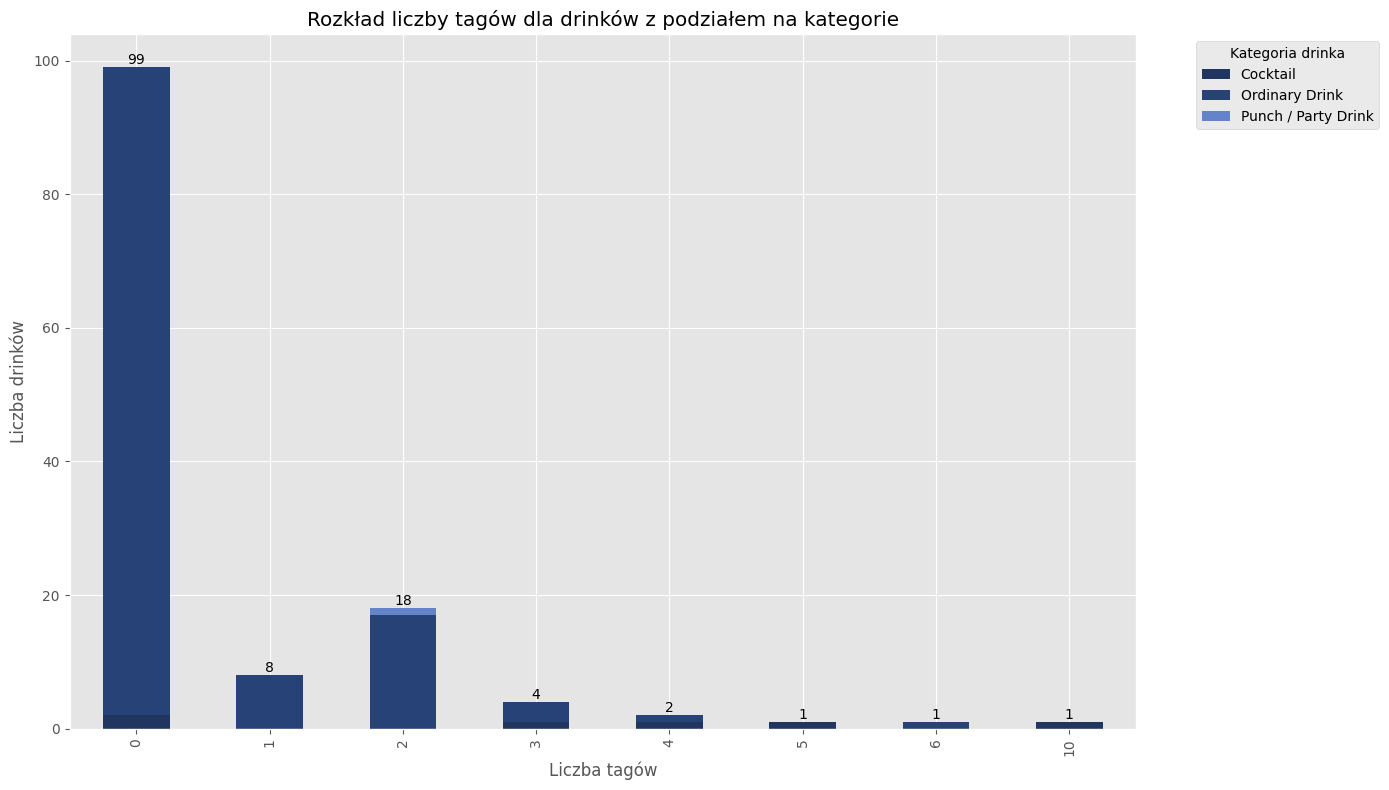

In [10]:
df["tag_count"] = df["tags"].apply(lambda x: len(x) if x is not None else 0)
tag_count_by_category = (
    df.groupby(["tag_count", "category"]).size().unstack(fill_value=0)
)
tag_count_by_category.plot(kind="bar", stacked=True, figsize=(14, 8))
plt.xlabel("Liczba tagów")
plt.ylabel("Liczba drinków")
plt.title("Rozkład liczby tagów dla drinków z podziałem na kategorie")
plt.legend(title="Kategoria drinka", bbox_to_anchor=(1.05, 1), loc="upper left")
for i, total in enumerate(tag_count_by_category.sum(axis=1)):
    plt.text(i, total, str(total), ha="center", va="bottom")
plt.tight_layout()
plt.show()

In [11]:
print(df["tags"].explode().value_counts())
# Ponieważ większość drinków nie jest otagowana, a najliczniejsza grupa to IBA, odkryłem, że ich organizacja
# rozpoznaje 102 drinki, a w danych mam tylko 23. Uznaję tagi za nieprzydatne do klasteryzacji, ponieważ:
# 1. Brak tagów dla większości drinków powoduje brak spójności w danych.
# 2. Niewielka liczba drinków z tagami IBA nie jest reprezentatywna.
# Dlatego nie będę dalej analizował tagów.

tags
IBA                    23
ContemporaryClassic    13
Classic                 9
Alcoholic               6
Brunch                  3
Beach                   3
Citrus                  2
Hangover                2
Dairy                   2
Sour                    2
StrongFlavor            2
Asia                    2
Expensive               1
Mild                    1
Vegan                   1
USA                     1
Vegetarian              1
Strong                  1
Christmas               1
Savory                  1
DinnerParty             1
Summer                  1
Chilli                  1
Nutty                   1
Cold                    1
Fruity                  1
Breakfast               1
NewEra                  1
Name: count, dtype: int64


In [12]:
df["instructions"].sample(5).values
# wygląda to jak świetne źródło danych do klasteryzacji, ale trzeba je odpowiednio przetworzyć,
# nie znam się za bardzo na processowaniu języka naturalnego, a zostawiłem sobie za mało czasu na zrobienie tego zadania,
# żeby teraz się tego uczyć, więc niestety nie wykorzystam tych danych do klasteryzacji. :(

array(['Pour all ingredients into shaker with ice cubes. Shake well. Strain in chilled cocktail glass.',
       'In a shaker half-filled with ice cubes, combine all of the ingredients. Shake well. Strain into a cocktail glass.',
       'In a mixing glass half-filled with ice cubes, combine all of the ingredients. Stir well. Strain into a cocktail glass.',
       'Shake all ingredients with ice and strain contents into a cocktail glass.',
       'Add dash of Angostura bitter onto sugar cube and drop it into champagne flute. Add cognac followed by gently pouring chilled champagne. Garnish with orange slice and maraschino cherry.'],
      dtype=object)

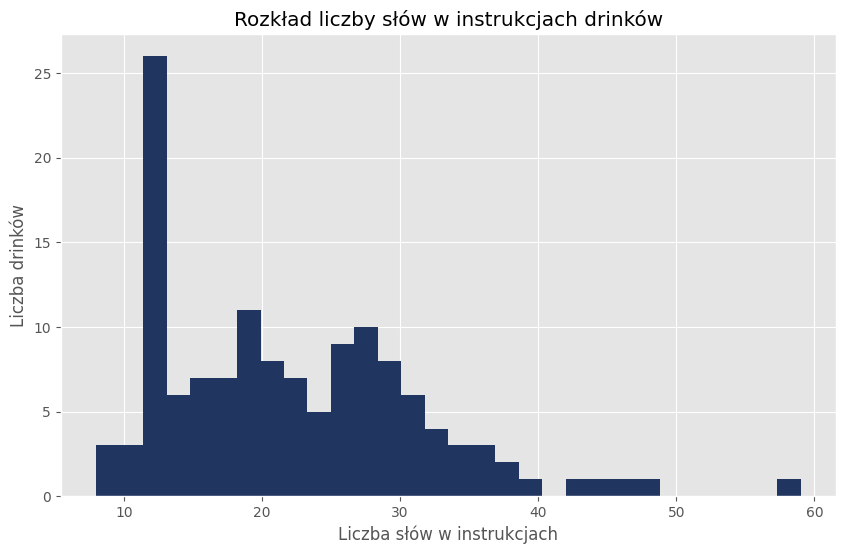

In [13]:
df["instructions_word_count"] = df["instructions"].apply(
    lambda x: len(x.split()) if x is not None else 0
)
ax = df["instructions_word_count"].plot(kind="hist", bins=30, figsize=(10, 6))
ax.set_xlabel("Liczba słów w instrukcjach")
ax.set_ylabel("Liczba drinków")
ax.set_title("Rozkład liczby słów w instrukcjach drinków")
plt.show()

In [14]:
import requests

df["image"] = None
for idx, url in df["imageUrl"].items():
    response = requests.get(url)
    df.at[idx, "image"] = response.content
print(df["image"][0])
print(len(df["image"].unique()))
print("api się wam wysypało, więc nie da się użyć obrazków do klasteryzacji :(")

b'File not found'
1
api się wam wysypało, więc nie da się użyć obrazków do klasteryzacji :(


In [15]:
print(df["alcoholic"].value_counts())
print("Wszystkie drinki są alkoholowe")

alcoholic
1    134
Name: count, dtype: int64
Wszystkie drinki są alkoholowe


In [16]:
print(f"Liczba unikalnych wartości updatedAt: {len(df['updatedAt'].unique())}")
print(f"Liczba unikalnych wartości createdAt: {len(df['createdAt'].unique())}")
identical_timestamps_count = df[df["createdAt"] == df["updatedAt"]].shape[0]
print(
    f"Liczba wierszy z identycznymi wartościami w kolumnach 'createdAt' i 'updatedAt': {identical_timestamps_count}"
)
updated_drinks = df[df["createdAt"] != df["updatedAt"]]
print("Drinki, które były aktualizowane:")
print(updated_drinks[["name"]])

Liczba unikalnych wartości updatedAt: 104
Liczba unikalnych wartości createdAt: 105
Liczba wierszy z identycznymi wartościami w kolumnach 'createdAt' i 'updatedAt': 129
Drinki, które były aktualizowane:
              name
0           Mojito
1    Old Fashioned
2  Long Island Tea
3          Negroni
4     Whiskey Sour


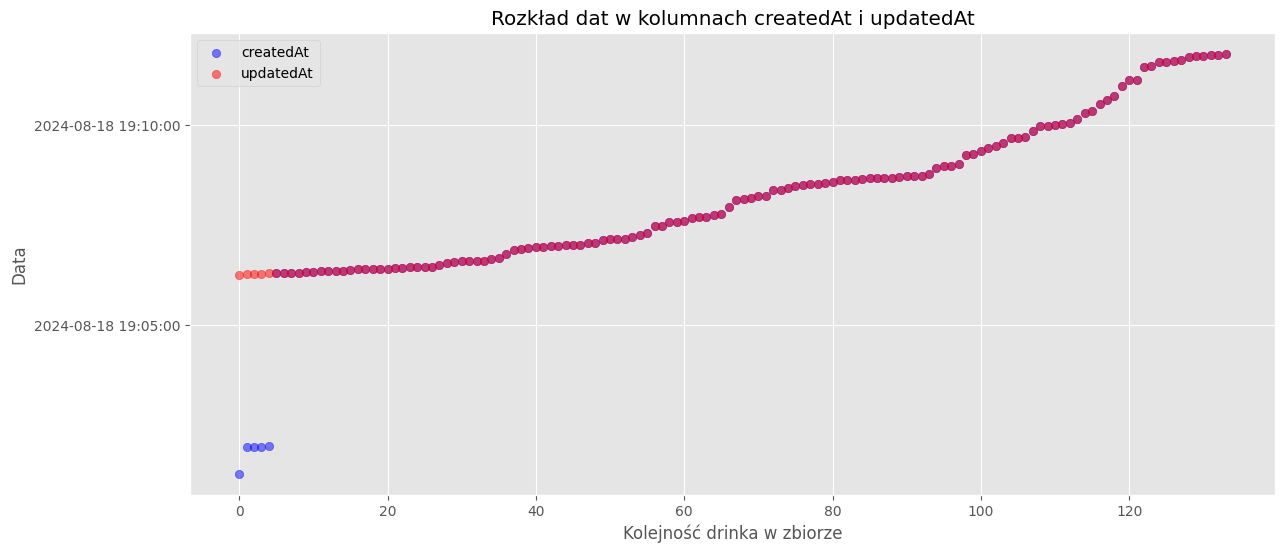

In [17]:
# Konwersja kolumn 'createdAt' i 'updatedAt' na datetime
df["createdAt"] = pd.to_datetime(df["createdAt"])
df["updatedAt"] = pd.to_datetime(df["updatedAt"])

# Tworzenie scatter plot dla kolumn 'createdAt' i 'updatedAt' z indeksem drinka na osi X
plt.figure(figsize=(14, 6))
plt.scatter(df.index, df["createdAt"], alpha=0.5, label="createdAt", color="blue")
plt.scatter(df.index, df["updatedAt"], alpha=0.5, label="updatedAt", color="red")
plt.xlabel("Kolejność drinka w zbiorze")
plt.ylabel("Data")
plt.title("Rozkład dat w kolumnach createdAt i updatedAt")
plt.legend()

# Formatowanie etykiet osi Y, aby wyświetlały pełną datę
plt.gca().yaxis.set_major_formatter(
    plt.matplotlib.dates.DateFormatter("%Y-%m-%d %H:%M:%S")
)

plt.show()

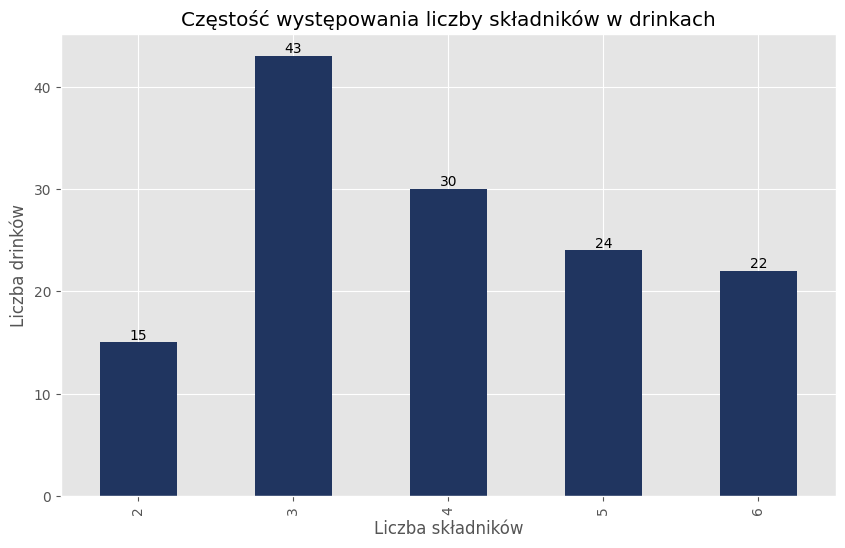

In [18]:
df["ingredient_count"] = df["ingredients"].apply(
    lambda x: len(x) if x is not None else 0
)
plt.figure(figsize=(10, 6))
ingredient_count_freq = df["ingredient_count"].value_counts().sort_index()
ingredient_count_freq.plot(kind="bar")
plt.xlabel("Liczba składników")
plt.ylabel("Liczba drinków")
plt.title("Częstość występowania liczby składników w drinkach")
plt.bar_label(plt.gca().containers[0])
plt.show()

In [19]:
df["ingredients"][0]

[{'id': 170,
  'name': 'Soda water',
  'description': None,
  'alcohol': 1,
  'type': None,
  'percentage': None,
  'imageUrl': None,
  'createdAt': '2024-08-18T19:01:57.000+00:00',
  'updatedAt': '2024-08-18T19:01:57.000+00:00'},
 {'id': 305,
  'name': 'Light Rum',
  'description': 'Light rums, also referred to as "silver" or "white" rums, in general, have very little flavor aside from a general sweetness. Light rums are sometimes filtered after aging to remove any colour. The majority of light rums come from Puerto Rico. Their milder flavors make them popular for use in mixed drinks, as opposed to drinking them straight. Light rums are included in some of the most popular cocktails including the Mojito and the Daiquiri.',
  'alcohol': 1,
  'type': 'Rum',
  'percentage': None,
  'imageUrl': 'https://cocktails.solvro.pl/images/ingredients/light-rum.png',
  'createdAt': '2024-08-18T19:02:37.000+00:00',
  'updatedAt': '2024-08-18T19:02:37.000+00:00',
  'measure': '2-3 oz '},
 {'id': 312,

In [20]:
exploded_ingredients_df = df.explode("ingredients")
split_ingredients(exploded_ingredients_df, 1)
split_ingredients(df)
# dataframe exploded ingredients będzie służył do eda, dataframe df będzie potem służył do klasteryzacji

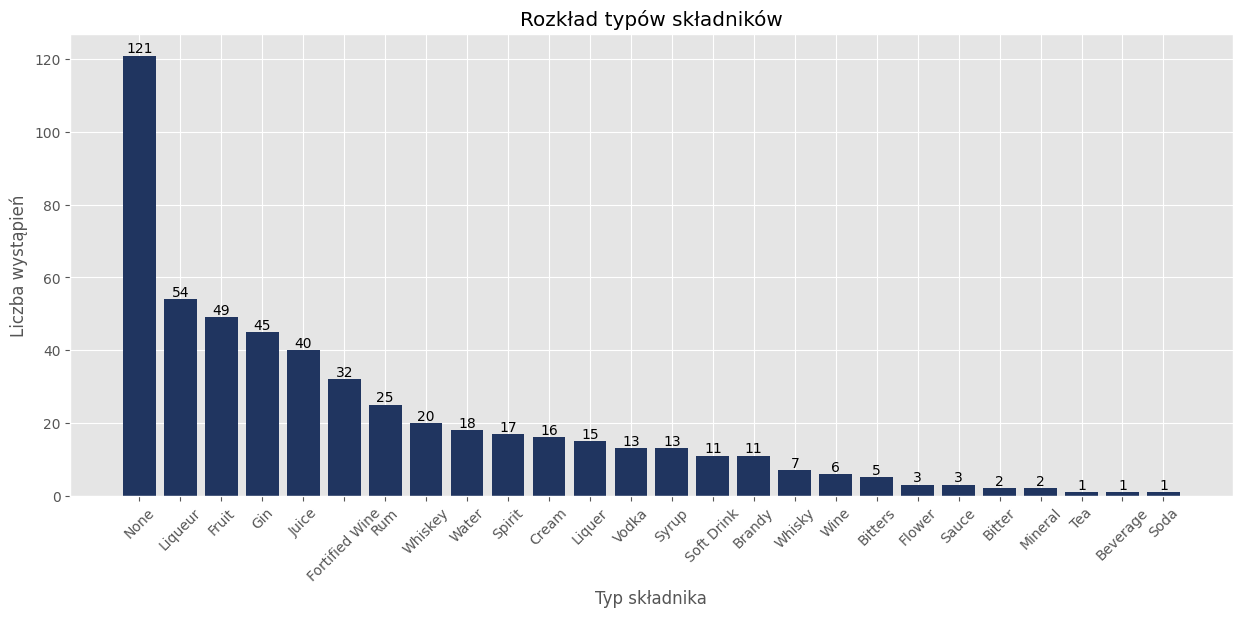

In [21]:
ingredient1_type_counts = (
    exploded_ingredients_df["ingredient1_type"].fillna("None").value_counts()
)
plt.figure(figsize=(15, 6))
plt.bar(ingredient1_type_counts.index, ingredient1_type_counts.values)
plt.title("Rozkład typów składników")
plt.xlabel("Typ składnika")
plt.ylabel("Liczba wystąpień")
plt.xticks(rotation=45)
plt.bar_label(plt.gca().containers[0])
plt.show()

In [22]:
# Widzimy wartości Liqueur i Liquer, które są tym samym typem, więc je połączymy.
replace_ingredient_type(df, "Liquer", "Liqueur")
# Whisky i Whiskey tak samo
replace_ingredient_type(df, "Whiskey", "Whisky")
# Bitters i Bitter tak samo
replace_ingredient_type(df, "Bitters", "Bitter")
# Mineral i Water tak samo
replace_ingredient_type(df, "Mineral", "Water")
# Sprawdźmy co znajduje się w rekordach o typowie Soda, Beverage i Soft Drink, bo też mam podejrzenie, że to ten sam typ
print(
    exploded_ingredients_df[exploded_ingredients_df["ingredient1_type"] == "Soda"][
        "ingredient1_name"
    ]
)
print(
    exploded_ingredients_df[exploded_ingredients_df["ingredient1_type"] == "Beverage"][
        "ingredient1_name"
    ]
)
print(
    exploded_ingredients_df[
        exploded_ingredients_df["ingredient1_type"] == "Soft Drink"
    ]["ingredient1_name"]
)
# Widzę, że można te typy połączyć
# zastanawiający jest Tomato juice w Soft Drink, a nie w kategorii Juice, tak w sumie zostawie, bo sok pomidorowy rzeczywiście jest bliżej w smaku do toniku niż do soku owocowego xd
replace_ingredient_type(df, "Soda", "Soft Drink")
replace_ingredient_type(df, "Beverage", "Soft Drink")

131    Lemon-lime soda
Name: ingredient1_name, dtype: object
28    Applejack
Name: ingredient1_name, dtype: object
2           Coca-Cola
9          Ginger Ale
39       Tomato Juice
40       Tomato Juice
41           Lemonade
66          Coca-Cola
67         Ginger Ale
80        Tonic Water
99     Sweet and Sour
113    Sweet and Sour
120        Ginger Ale
Name: ingredient1_name, dtype: object


In [23]:
print(
    exploded_ingredients_df[exploded_ingredients_df["ingredient1_type"].isna()][
        "ingredient1_name"
    ].unique()
)
# Tu widzę nazwy składników bez typu, uzupełniam je
replace_ingredient_type_by_name(df, "Soda water", "Water")
replace_ingredient_type_by_name(df, "Ice", "Water")
replace_ingredient_type_by_name(df, "Club Soda", "Water")
# w międzyczasie zastanawiam się do czego przyporządkować Sugar, Powdered Sugar
print(
    exploded_ingredients_df[exploded_ingredients_df["ingredient1_type"] == "Syrup"][
        "ingredient1_name"
    ].unique()
)
print(
    exploded_ingredients_df[exploded_ingredients_df["ingredient1_type"] == "Cream"][
        "ingredient1_name"
    ].unique()
)
replace_ingredient_type_by_name(df, "Sugar", "Syrup")
replace_ingredient_type_by_name(df, "Powdered Sugar", "Syrup")
replace_ingredient_type_by_name(df, "Cherry", "Fruit")
replace_ingredient_type_by_name(df, "Olive", "Fruit")  # dodgy, ale gdzieś musi być
replace_ingredient_type_by_name(df, "Maraschino Cherry", "Fruit")
replace_ingredient_type_by_name(
    df, "Lemon Peel", "Bitter"
)  # niby cytryna, ale ma smak jak bitter wg mnie
replace_ingredient_type_by_name(df, "Nutmeg", "Spice")
replace_ingredient_type_by_name(df, "Lemon vodka", "Liqueur")
replace_ingredient_type_by_name(df, "Egg White", "Egg")  # nowa kategoria
replace_ingredient_type_by_name(df, "Egg Yolk", "Egg")
replace_ingredient_type_by_name(df, "Egg", "Egg")
replace_ingredient_type_by_name(df, "Benedictine", "Liqueur")
replace_ingredient_type_by_name(df, "Bitters", "Bitter")
replace_ingredient_type_by_name(df, "Banana", "Fruit")
replace_ingredient_type_by_name(df, "Banana liqueur", "Liqueur")
replace_ingredient_type_by_name(df, "Celery Salt", "Salt")  # nowa kategoria

['Soda water' 'Sugar' 'Powdered Sugar' 'Cherry' 'Olive' 'Ice'
 'Maraschino Cherry' 'Lemon Peel' 'Nutmeg' 'Lemon vodka' 'Egg White'
 'Club Soda' 'Benedictine' 'Bitters' 'Banana' 'Celery Salt' 'Egg'
 'Egg Yolk']
['Grenadine' 'Sugar Syrup' 'Orgeat Syrup' 'Raspberry syrup']
['Light Cream' 'Whipped Cream' 'Chocolate Ice-cream' 'Heavy cream']


In [24]:
# patrzę co zrobić z tym Tea w danych, ale chyba trzeba zostawić mimo tylko 1 wystąpienia
print(
    exploded_ingredients_df[exploded_ingredients_df["ingredient1_type"] == "Tea"][
        "id"
    ].to_string(index=False)
)
print(
    exploded_ingredients_df[exploded_ingredients_df["id"] == 11029][
        "ingredients"
    ].to_string(index=False)
)

11029
{'id': 18, 'name': 'Amaretto', 'description': '...
{'id': 486, 'name': 'Tea', 'description': None,...
{'id': 515, 'name': 'Whipped Cream', 'descripti...


In [25]:
print(
    exploded_ingredients_df[exploded_ingredients_df["ingredient1_type"] == "Sauce"][
        "ingredient1_name"
    ].to_string(index=False)
)
# nic z tym nie zrobię

       Tabasco Sauce
       Tabasco Sauce
Worcestershire Sauce


In [26]:
print(
    exploded_ingredients_df[exploded_ingredients_df["ingredient1_type"] == "Spirit"][
        "ingredient1_name"
    ].unique()
)
print(
    exploded_ingredients_df[exploded_ingredients_df["ingredient1_type"] == "Brandy"][
        "ingredient1_name"
    ].unique()
)
# brandy to rodzaj alkoholu destylowanego i są już jakieś brandy w 'spirytach' więc łącze
replace_ingredient_type(df, "Brandy", "Spirit")

['Tequila' 'Brandy' 'Cachaca']
['Apricot Brandy' 'Blackberry Brandy' 'Apple Brandy' 'Cognac'
 'Peach brandy' 'Coffee Brandy']


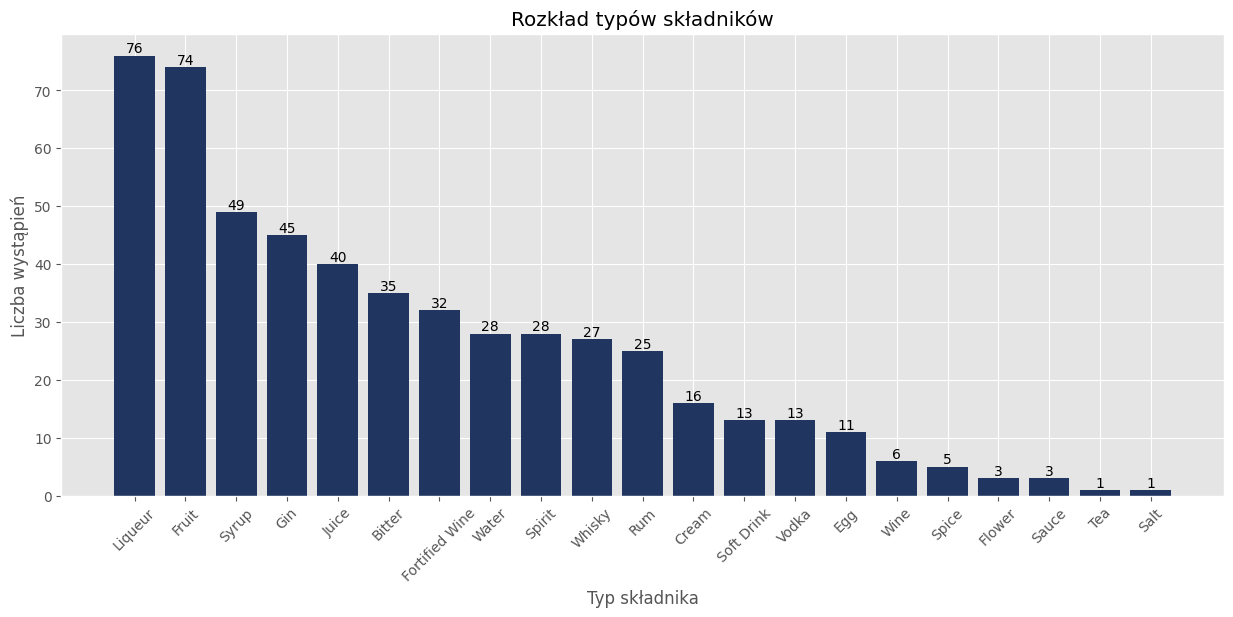

In [27]:
# chcę zobaczyć podział na typy składników po zmianach
exploded_ingredients_df = df.explode("ingredients")
split_ingredients(exploded_ingredients_df, 1)
split_ingredients(df)
ingredient1_type_counts = (
    exploded_ingredients_df["ingredient1_type"].fillna("None").value_counts()
)
plt.figure(figsize=(15, 6))
plt.bar(ingredient1_type_counts.index, ingredient1_type_counts.values)
plt.title("Rozkład typów składników")
plt.xlabel("Typ składnika")
plt.ylabel("Liczba wystąpień")
plt.xticks(rotation=45)
plt.bar_label(plt.gca().containers[0])
plt.show()

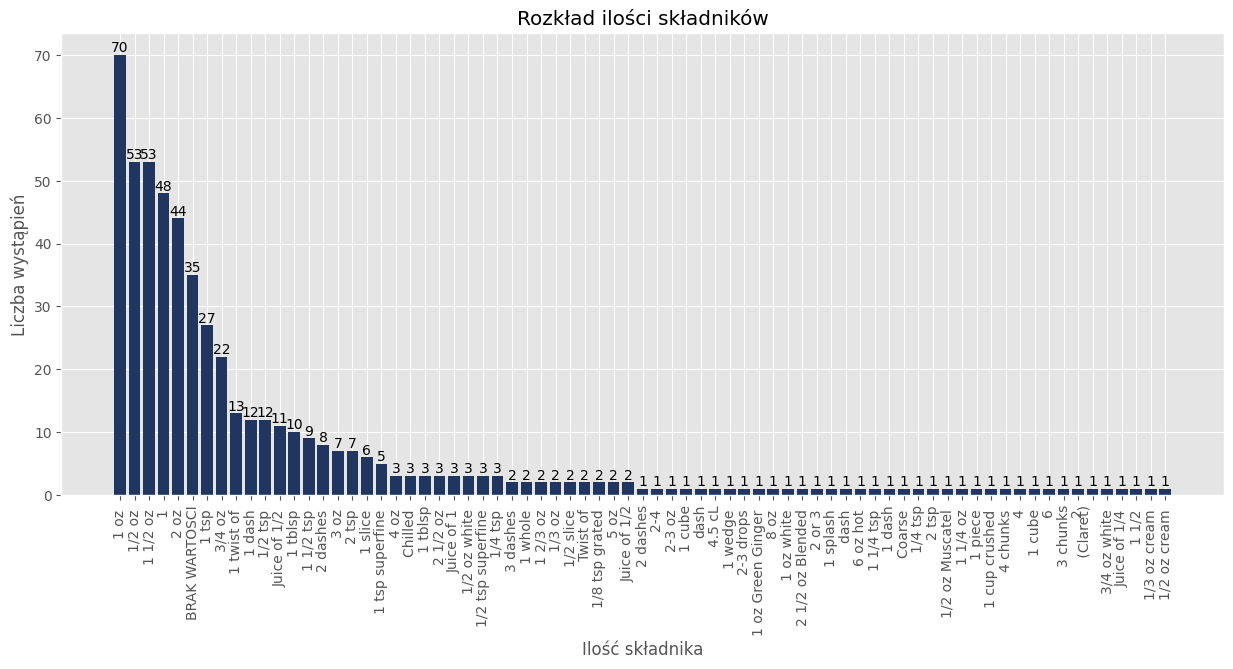

In [28]:
exploded_ingredients_df = df.explode("ingredients")
split_ingredients(exploded_ingredients_df, 1)
split_ingredients(df)
ingredient1_type_counts = (
    exploded_ingredients_df["ingredient1_measure"]
    .fillna("BRAK WARTOSCI")
    .value_counts()
)
plt.figure(figsize=(15, 6))
plt.bar(ingredient1_type_counts.index, ingredient1_type_counts.values)
plt.title("Rozkład ilości składników")
plt.xlabel("Ilość składnika")
plt.ylabel("Liczba wystąpień")
plt.xticks(rotation=90)
plt.bar_label(plt.gca().containers[0])
plt.show()

In [29]:
# będę próbował zamienić wszystkie ilości na wartość od 0 do 1,
# myślałem jak to zrobić automatycznie, ale biorąc pod uwagę jakie wartości występują w danych,
# to uważam, że ręcznie tego nie zrobię idealnie, a co dopiero próbować robić jakiś algorytm
print(exploded_ingredients_df["ingredient1_measure"].fillna("None").unique())

['None' '2-3 oz ' 'Juice of 1 ' '2-4 ' '2 tsp ' 'dash' '1 cube' '2 dashes'
 '4.5 cL' '1/2 oz ' 'Juice of 1/2 ' '1 splash ' '1 oz ' '1/2 tsp '
 '1/2 slice ' '2 oz ' '1 ' '1/3 oz ' '1 2/3 oz ' '1 1/2 oz ' '1 tsp '
 'dash ' '2 1/2 oz Blended ' '2 or 3 ' '1 twist of ' '3/4 oz ' '8 oz '
 '1 dash ' 'Twist of ' '2 dashes ' '1/2 oz white ' '1 oz white '
 '1 tblsp ' '1 1/2 tsp ' '6 oz hot ' 'Chilled ' '1 oz Green Ginger '
 '1 slice ' '1 wedge ' '2-3 drops ' '3 oz ' 'Coarse ' '1 1/4 tsp '
 '3 dashes ' '1 tsp superfine ' '1/2 tsp superfine ' '1 whole '
 '1/8 tsp grated ' '2 1/2 oz ' '2 tsp' '1/4 tsp' '1 tblsp' '1 dash'
 '1 piece ' '1 1/4 oz ' '5 oz ' '1/2 oz Muscatel ' '4 oz ' '1/4 tsp '
 '1 cup crushed ' '6 ' '4 chunks ' '4 ' '1 cube ' '3 chunks' '2 '
 'Juice of 1/2' ' (Claret)\n' '3/4 oz white ' 'Juice of 1/4 ' '1 1/2 '
 '1/3 oz cream ' '1/2 oz cream ']


In [30]:
exploded_ingredients_df[exploded_ingredients_df["ingredient1_measure"].isna()][
    "ingredient1_name"
].unique()
# widzę, że te składniki bez miary to są składniki, które dodaje się na końcu, aby dopełnić szklankę,
# więc przyjmę dla nich wartość 0.2
replace_measure(df, None, 0.2)
replace_measure(df, "2-3 oz ", 0.3125)  # największa wartość w danych to 8oz
replace_measure(df, "Juice of 1 ", 1)  # największa wartość w danych to Juice of 1
replace_measure(df, "2-4 ", 0.5)  # największa wartość w danych to 6
replace_measure(df, "2 tsp ", 1)  # największa wartość w danych to 2tsp
replace_measure(df, "dash", 0.33)  # największa wartość w danych to 3 dashes
replace_measure(df, "1 cube", 1)  # największa wartość w danych to 1 cube
replace_measure(df, "2 dashes", 0.66)
replace_measure(
    df, "4.5 cL", 0.0825
)  # to jest w przybliżeniu 0.66oz, największa wartość w danych to 8oz
replace_measure(df, "1/2 oz ", 0.0625)
replace_measure(df, "Juice of 1/2 ", 0.5)
replace_measure(
    df, "1 splash ", 0.33
)  # to się odnosi pewnie do tych samych rzeczy co dash, uznam, że 1 dash = 1 splash
replace_measure(df, "1 oz ", 0.125)
replace_measure(df, "1/2 tsp ", 0.25)
replace_measure(
    df, "1/2 slice ", 0.25
)  # uznam, że 1 slice = 0.5 wedge, największa wartość w danych to 1 wedge
replace_measure(df, "2 oz ", 0.25)
replace_measure(df, "1 ", 0.166)
replace_measure(df, "1/3 oz ", 0.04166)
replace_measure(df, "1 2/3 oz ", 0.20833)
replace_measure(df, "1 1/2 oz ", 0.1875)
replace_measure(df, "1 tsp ", 0.5)
replace_measure(df, "dash ", 0.33)
replace_measure(df, "2 1/2 oz Blended ", 0.3125)
replace_measure(df, "2 or 3 ", 0.4166)  # uśredniam do 2.5
replace_measure(df, "1 twist of ", 1)  # tu chodzi o skórkę cytryny, dam 1
replace_measure(df, "3/4 oz ", 0.09375)
replace_measure(df, "8 oz ", 1)
replace_measure(df, "1 dash ", 0.33)
replace_measure(df, "Twist of ", 1)
replace_measure(df, "2 dashes ", 0.66)
replace_measure(df, "1/2 oz white ", 0.0625)
replace_measure(df, "1 oz white ", 0.125)
replace_measure(df, "1 tblsp ", 1)  # Uznaje że 1tblsp = 2tsp
replace_measure(df, "1 1/2 tsp ", 0.75)
replace_measure(df, "6 oz hot ", 0.75)
replace_measure(df, "Chilled ", 1)  # 1?
replace_measure(df, "1 oz Green Ginger ", 0.125)
replace_measure(df, "1 slice ", 0.5)
replace_measure(df, "1 wedge ", 1)
replace_measure(df, "2-3 drops ", 1)  # 1?
replace_measure(df, "3 oz ", 0.375)
replace_measure(df, "Coarse ", 1)
replace_measure(df, "1 1/4 tsp ", 0.625)
replace_measure(df, "3 dashes ", 1)
replace_measure(df, "1 tsp superfine ", 0.25)
replace_measure(df, "1/2 tsp superfine ", 0.125)
replace_measure(df, "1 whole ", 1)
replace_measure(df, "1/8 tsp grated ", 0.03125)
replace_measure(df, "2 1/2 oz ", 0.3125)
replace_measure(df, "2 tsp", 1)
replace_measure(df, "1/4 tsp", 0.125)
replace_measure(df, "1 tblsp", 1)
replace_measure(df, "1 dash", 0.33)
replace_measure(df, "1 piece ", 1)
replace_measure(df, "1 1/4 oz ", 0.15625)
replace_measure(df, "5 oz ", 0.625)
replace_measure(df, "1/2 oz Muscatel ", 0.0625)
replace_measure(df, "4 oz ", 0.5)
replace_measure(df, "1/4 tsp ", 0.125)
replace_measure(df, "1 cup crushed ", 1)
replace_measure(df, "6 ", 1)
replace_measure(df, "4 chunks ", 1)
replace_measure(df, "4 ", 0.66)
replace_measure(df, "1 cube ", 1)
replace_measure(df, "3 chunks", 0.75)
replace_measure(df, "2 ", 0.33)
replace_measure(df, "Juice of 1/2", 0.5)
replace_measure(df, " (Claret)\n", 1)
replace_measure(df, "3/4 oz white ", 0.09375)
replace_measure(df, "Juice of 1/4 ", 0.25)
replace_measure(df, "1 1/2 ", 0.1875)
replace_measure(df, "1/3 oz cream ", 0.04166)
replace_measure(df, "1/2 oz cream ", 0.0625)

In [31]:

split_ingredients(df)
df.to_pickle("../data/cocktail_dataset_v1.pkl")